In [8]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO
                   )

logging.info('Importing standard python libraries')
from pathlib import Path

logging.info('Importing third party python libraries')
import numpy as np
from scipy.special import erf
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import xarray as xr
import zarr
import f90nml
import cmocean.cm as cmo

logging.info("Importing custom python libraries")
import pvcalc

09-Mar-23 12:18:22 - Importing standard python libraries
09-Mar-23 12:18:22 - Importing third party python libraries
09-Mar-23 12:18:22 - Importing custom python libraries


In [9]:
logging.info('Setting paths')
base_path = Path('/work/n01/n01/fwg/irminger-proj')
raw_path = base_path / 'data/raw'
interim_path = base_path / 'data/interim'

processed_path = base_path / 'data/processed'
figure_path = base_path / 'figures'
out_path = processed_path / 'stdwmt.zarr'

log_path = base_path / 'src/post_processing/.tmp/slurm-out'
dask_worker_path = base_path / 'src/post_processing/.tmp/dask-worker-space'
env_path = base_path / 'irminger-proj/bin/activate'

logging.info("Opening ensemble")
run_path = interim_path / "ensemble.zarr"
assert run_path.exists()
#assert not out_path.exists()
ds = xr.open_zarr(run_path, chunks={'Z': -1,
                                    'XC': -1,
                                    'time': 1,
                                    'run': 1})#.sel(run=37)

logging.info("Extracting namelist data")
data_nml = f90nml.read(raw_path / '2d-models/input_data_files_a/data')
delta_t = data_nml['parm03']['deltat']
f0 = ds.attrs['f0']
beta = ds.attrs['beta']
no_slip_bottom = ds.attrs['no_slip_bottom']
no_slip_sides = ds.attrs['no_slip_sides']
rhonil = data_nml['parm01']['rhonil']
talpha = data_nml['parm01']['talpha']

logging.info("Creating grid and doing density calculations")
grid = pvcalc.create_xgcm_grid(ds)
ds['drL'] = pvcalc.create_drL_from_dataset(ds)
ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])
_, _, ds['db_dz'] = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)

ds['ZuMask'] = xr.where(grid.interp(ds['maskC'], ['Z'], to={'Z': 'right'}, boundary='fill') == 0,
                        np.nan, 1)

ds['db_dz'] = ds['db_dz'] * ds['ZuMask']

ds['rhoTEND'] = - rhonil * talpha * ds['TOTTTEND']
ds['bTEND'] = pvcalc.calculate_buoyancy(ds['rhoTEND'])
ds['hTEND'] = ds['bTEND'] / grid.interp(ds['db_dz'], 'Z', boundary='fill')
db = grid.diff(ds['b'], 'Z', boundary='extend', to="right")

ds['hTEND2'] = - 1 / np.square(ds['db_dz']) * grid.diff(ds['bTEND'], 'Z', to="right", boundary="extend") / ds['drL'] * db

days = 24 * 60 * 60
ds["tau_int"] = np.sqrt(2 * np.pi) \
              * ds["wind_stress"] * ds["wind_duration"] \
              * erf(10.5 * days / np.sqrt(2) / ds["wind_duration"]) * 1e-5


logging.info("Creating wmt dataset")

density_class_boundaries = np.linspace(1026.8, 1027.25, 130)

#np.array([1026.92, 1026.98, 1027.05, 1027.1211])
assert np.all(np.diff(density_class_boundaries) > 0)


class_coords = {'classs': ('classs',
                           range(0, len(density_class_boundaries) + 1)),
                
                'rho_upper': ('classs',
                              np.insert(density_class_boundaries, 0, 0)),
                
                'rho_lower': ('classs',
                              np.append(density_class_boundaries, np.inf)),
                
                'XC': ds['XC'],
                'XG': ds['XG'],
                'YC': ds['YC'],
                'YG': ds['YG'],
                'Z': ds['Z'],
                'Zl': ds['Zl'],
                'Zu': ds['Zu'],
                'Zp1': ds['Zp1'],}

ds_class = xr.Dataset(coords=class_coords)
ds['NaNmaskC'] = xr.where(ds['maskC'] == 1, 1, np.NaN)
ds_class['rho'] = ds['rho'] * ds['NaNmaskC'] * xr.ones_like(ds_class['classs'])

ds_class['mask'] = xr.where(ds_class['rho'] <= ds_class['rho_lower'],
                            True,
                            False) * xr.where(ds_class['rho'] > ds_class['rho_upper'],
                                              True,
                                              False)
                            
ds_class['rhoL'] = grid.interp(ds['rho'], 'Z', to="right", boundary="extend")
ds_class['maskL'] = xr.where(ds_class['rhoL'] <= ds_class['rho_lower'],
                            True,
                            False) * xr.where(ds_class['rhoL'] > ds_class['rho_upper'],
                                              True,
                                              False)

def invert_bool_mask(da):
    return xr.where(da == True, False, True)

def dVol_dt(db_dz, classMask, hTend):
    db_dz_mask = xr.where(db_dz == 0, 0, 1)
    hTends = classMask * hTend * db_dz_mask
    # hTends = classMask * (invert_bool_mask(classMask.shift({'Z': 1})) + -1 * invert_bool_mask(classMask.shift({'Z': -1}))) * hTend * db_dz_mask
    VolTend = (hTends.sum('Zl') * hTend['dxF']).sum('XC')
    return VolTend

#ds_class['volTEND'] = dVol_dt(ds['db_dz'], ds_class['maskL'], ds['hTEND2'])
logging.info("Not currently calculating volume tendency as method is flawed")

ds_class["vol"] = (ds_class["mask"] * ds["drF"] * ds["dxF"]).sum(["Z", "XC"])
ds_class["vol"].attrs = {"units": "m3 m-1"}

ds_class['volANOM'] = ds_class['vol'] - ds_class['vol'].isel(time=0)
ds_class["volANOM"].attrs = {"units": "m3 m-1"}


tdays = ds_class['time'].values.astype('float32') * 1e-9 / 24 / 60 / 60
ds_class = ds_class.assign_coords({'tdays': ('time',
                                             tdays,
                                             {'units': 'days'})}) 


ds_class = ds_class.drop(['rho', 'mask', 'rhoL', 'maskL']).squeeze()

def create_encoding_for_ds(ds, clevel):
    compressor = zarr.Blosc(cname="zstd", clevel=clevel, shuffle=2)
    enc = {x: {"compressor": compressor} for x in ds}
    return enc

09-Mar-23 12:18:25 - Setting paths
09-Mar-23 12:18:25 - Opening ensemble
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "run" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
09-Mar-23 12:18:25 - Extracting namelist data
09-Mar-23 12:18:25 - Creating grid and doing density calculations
09-Mar-23 12:18:29 - Creating wmt dataset
09-Mar-23 12:18:29 - Not currently calculating volume tendency as method is flawed


In [10]:
dvol_dt = ds_class["vol"].diff("time") / (ds_class["time"].diff("time").astype(float) * 1e-9)

In [11]:
logging.info("Launching cluster")
scluster = SLURMCluster(queue='standard',
                        account="n01-siAMOC",
                        job_cpu=256,
                        log_directory=log_path,
                        local_directory=dask_worker_path,
                        cores=24,
                        processes=24,  # Can change this
                        memory="256 GiB",
                        job_directives_skip= ['#SBATCH --mem='],  
                        walltime="00:10:00",
                        death_timeout=60,
                        interface='hsn0',
                        job_extra_directives=["--qos=standard", "--partition=standard"],
                        job_script_prologue=['module load cray-python',
                                'source {}'.format(str(env_path.absolute()))]
                    )


client = Client(scluster)
logging.info("Scaling cluster")
scluster.adapt(minimum_jobs=1, maximum_jobs=16,
               interval="1000 ms", wait_count=30)

09-Mar-23 12:18:42 - Launching cluster
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37455 instead
  warnings.warn(
09-Mar-23 12:18:42 - State start
09-Mar-23 12:18:42 -   Scheduler at:   tcp://10.253.2.72:38769
09-Mar-23 12:18:42 -   dashboard at:         10.253.2.72:37455
09-Mar-23 12:18:42 - Receive client connection: Client-881373c9-be74-11ed-8c6e-b42e99a2321f
09-Mar-23 12:18:42 - Starting established connection to tcp://10.253.2.72:34896
09-Mar-23 12:18:42 - Scaling cluster
09-Mar-23 12:18:42 - Adaptive scaling started: minimum=24 maximum=384


In [12]:
dvol_dt

<xarray.DataArray (run: 37, time: 167, classs: 131)>
dask.array<truediv, shape=(37, 167, 131), dtype=float64, chunksize=(1, 1, 131), chunktype=numpy.ndarray>
Coordinates:
  * classs     (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper  (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower  (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
    YC         float32 12.5
    YG         float32 0.0
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * run        (run) int64 0 6 7 8 9 11 12 13 14 ... 39 41 42 43 44 46 47 48 49
  * time       (time) timedelta64[ns] 0 days 03:00:00 ... 20 days 21:00:00
    tdays      (time) float32 0.125 0.25 0.375 0.5 ... 20.5 20.62 20.75 20.87

In [13]:
import matplotlib.pyplot as plt

In [ ]:
mn_transformation = -dvol_dt.cumsum(dim="classs").mean(dim="time") * 1e-3
mn_transformation.load()

In [15]:
mn_transformation

<xarray.DataArray (run: 37, classs: 131)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.45425920e-22, -1.45425920e-22, -1.45425920e-22],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         9.26570863e-21,  9.26570863e-21,  9.26570863e-21],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.16756239e-20, -1.16756239e-20, -1.16756239e-20],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         5.94376511e-20,  5.94376511e-20,  5.94376511e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.38419789e-20, -6.38419789e-20, -6.38419789e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.85579338e-20, -6.85579338e-20, -6.85579338e-20]])
Coordinates:
  * classs     (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper  (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower  (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
    YC         float32 12.5
    YG         float32 0.0
  * run        (run) int64 0 6 7 8 9 11 12 13 14 ... 39 41 42 43 44 46 47 48 49

The below is transformation plotted in units of Sv/km. Note that the time mean looks very different to the instantaneous transformation rate. This is due to there being zero transformation towards the start and end of the integrations. Perhaps we should take the daily mean and then plot as a function of time? Or even the 1.5, 2.5 or 3 day mean?

In [ ]:
logging.info("Plotting")
mn_transformation = -dvol_dt.cumsum(dim="classs").mean(dim="time") * 1e-3
plt.plot(mn_transformation["rho_lower"], mn_transformation)


In [ ]:
for run in mn_transformation["run"]:
    plt.plot(mn_transformation["rho_lower"],
             mn_transformation.sel(run=run),
             c=cmo.tempo(ds["wind_stress"].sel(run=run) / ds["wind_stress"].min(), alpha=0.5))

In [ ]:
mn_transformation.load()

In [ ]:
for run in mn_transformation["run"]:
    plt.plot(mn_transformation["rho_lower"],
             mn_transformation.sel(run=run),
             c=cmo.tempo(ds["wind_duration"].sel(run=run) / ds["wind_duration"].max(), alpha=0.5))

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
import matplotlib.font_manager as fm

logging.info("Setting plotting defaults")
logging.info('Setting plotting defaults')
fpath = Path('/home/n01/n01/fwg/.local/share/fonts/PTSans-Regular.ttf')
assert fpath.exists()
font_prop = fm.FontProperties(fname=fpath)
plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

# font size
mpl.use("pgf")
plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rcParams['axes.titlesize'] = 10
plt.rcParams["text.latex.preamble"] = "\\usepackage{euler} \\usepackage{paratype}  \\usepackage{mathfont} \\mathfont[digits]{PT Sans}"
plt.rcParams["pgf.preamble"] = plt.rcParams["text.latex.preamble"]
plt.rc('text', usetex=False)
# output
dpi = 600
text_width = 6


09-Mar-23 12:35:50 - Setting plotting defaults
09-Mar-23 12:35:50 - Setting plotting defaults


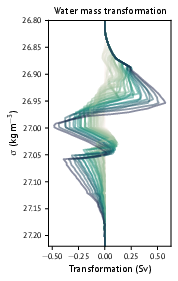

In [22]:
fig, ax = plt.subplots(figsize=(2.6, 4))
for run in mn_transformation["run"]:
    ax.plot(mn_transformation.sel(run=run) * 200,
             mn_transformation["rho_lower"] - 1000,
             c=cmo.tempo(ds["tau_int"].sel(run=run) / ds["tau_int"].min(), alpha=0.5))
    
ax.set_ylim(27.22, 26.8)
ax.set_xlabel("Transformation (Sv)")
ax.set_ylabel("$\\sigma$ (kg\,m$^{-3}$)")
ax.set_title("Water mass transformation")
fig.tight_layout()


In [ ]:
figure_name = "water_mass_trans.pdf"
fig.savefig(figure_path / figure_name, dpi=dpi)

In [23]:
mn_transformation.to_netcdf(processed_path / "Transformation.nc")

In [28]:
mn_transformation = xr.open_dataarray(processed_path / "Transformation.nc")
mn_transformation.load()

<xarray.DataArray (run: 37, classs: 131)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.45425920e-22, -1.45425920e-22, -1.45425920e-22],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         9.26570863e-21,  9.26570863e-21,  9.26570863e-21],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.16756239e-20, -1.16756239e-20, -1.16756239e-20],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         5.94376511e-20,  5.94376511e-20,  5.94376511e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.38419789e-20, -6.38419789e-20, -6.38419789e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.85579338e-20, -6.85579338e-20, -6.85579338e-20]])
Coordinates:
  * classs     (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper  (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower  (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
    YC         float32 12.5
    YG         float32 0.0
  * run        (run) int64 0 6 7 8 9 11 12 13 14 ... 39 41 42 43 44 46 47 48 49

In [31]:
mn_transformation["tau_int"] = ds["tau_int"]
mn_transformation.load()

<xarray.DataArray (run: 37, classs: 131)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.45425920e-22, -1.45425920e-22, -1.45425920e-22],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         9.26570863e-21,  9.26570863e-21,  9.26570863e-21],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -1.16756239e-20, -1.16756239e-20, -1.16756239e-20],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         5.94376511e-20,  5.94376511e-20,  5.94376511e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.38419789e-20, -6.38419789e-20, -6.38419789e-20],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -6.85579338e-20, -6.85579338e-20, -6.85579338e-20]])
Coordinates:
  * classs     (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper  (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower  (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
    YC         float32 12.5
    YG         float32 0.0
  * run        (run) int64 0 6 7 8 9 11 12 13 14 ... 39 41 42 43 44 46 47 48 49
    tau_int    (run) float64 0.0 -0.2256 -0.4512 -0.6733 ... -4.061 -6.06 -7.831

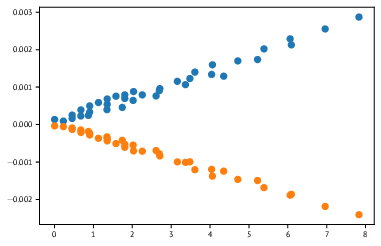

In [37]:
max_wmt = mn_transformation.max("classs")
min_wmt = mn_transformation.min("classs")
plt.figure()
plt.scatter(-max_wmt["tau_int"], max_wmt)
plt.scatter(-min_wmt["tau_int"], min_wmt)


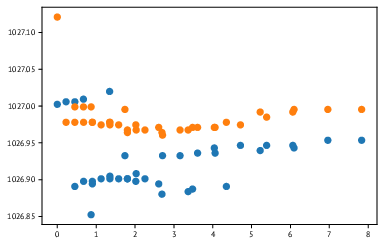

In [46]:
max_trans_density_idx = mn_transformation.argmax(dim="classs")
max_trans_density = mn_transformation["rho_lower"].isel(classs=max_trans_density_idx)

min_trans_density_idx = mn_transformation.argmin(dim="classs")
min_trans_density = mn_transformation["rho_lower"].isel(classs=min_trans_density_idx)

plt.figure()
plt.scatter(-mn_transformation["tau_int"], max_trans_density)
plt.scatter(-mn_transformation["tau_int"], min_trans_density)



In [47]:
scluster.close()
client.close()

09-Mar-23 12:46:19 - Adaptive stop
09-Mar-23 12:46:20 - Scheduler closing...
09-Mar-23 12:46:20 - Scheduler closing all comms
09-Mar-23 12:46:20 - Adaptive stop
09-Mar-23 12:58:39 - Event loop was unresponsive in Scheduler for 3.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
09-Mar-23 13:08:54 - Event loop was unresponsive in Scheduler for 4.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
09-Mar-23 13:22:20 - Event loop was unresponsive in Scheduler for 3.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
09-Mar-23 13:31:38 - Event loop was unresponsive in Scheduler for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
09-Mar-23 13:43